In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, optimizers, compling_multiorder, models_multi_order, blocks
reload(TN_utils)
reload(models_multi_order)
reload(compling_multiorder)
reload(blocks)

<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.py'>

In [1]:
import theano

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)


In [3]:
feature_vec_list = []
gt_vec_list = []
for i in [0, 1, 2]:
    fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=i, i_indiv=0, mask_thresh=0.5)
    feature_vec_list.append(fe_vec)
    gt_vec_list.append(gt_vec)

(430080, 31, 1) (430080, 1) (430080,)
(430080, 43, 10) (430080, 10) (430080,)
(430080, 37, 18) (430080, 18) (430080,)


In [4]:
len(feature_vec_list)

3

In [20]:
permu_index = np.random.permutation(range(len(mask_vec.nonzero()[0])))
dataset_list = []
norm_coef_list = []
gt_norm_coef_list = []
for i in range(len(feature_vec_list)):
    data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(feature_vec_list[i], gt_vec_list[i], mask_vec, 
                                                            permu_index=permu_index)
    dataset_list.append(data_set)
    norm_coef_list.append(norm_coef)
    gt_norm_coef_list.append(gt_norm_coef)

[16243  3190    76 ...,  1707 16092 21122]
(21485, 1, 31)
(21485, 1)
(5372, 1, 31)
(5372, 1)
[16243  3190    76 ...,  1707 16092 21122]
(21485, 10, 43)
(21485, 10)
(5372, 10, 43)
(5372, 10)
[16243  3190    76 ...,  1707 16092 21122]
(21485, 18, 37)
(21485, 18)
(5372, 18, 37)
(5372, 18)


In [6]:
dataset_list[1][1].shape

(21485, 10)

In [7]:
train_feature_vec_list = [np.concatenate([dataset_list[0][0], np.zeros_like(dataset_list[0][0])], axis=1),
                         dataset_list[1][0], dataset_list[2][0]]
train_gt_vec = dataset_list[1][1]
test_feature_vec_list = [np.concatenate([dataset_list[0][2], np.zeros_like(dataset_list[0][2])], axis=1),
                         dataset_list[1][2], dataset_list[2][2]]
test_gt_vec = dataset_list[1][3]

In [8]:
print [d.shape for d in train_feature_vec_list], train_gt_vec.shape,  [d.shape for d in test_feature_vec_list], test_gt_vec.shape

[(21485, 2, 31), (21485, 10, 43), (21485, 18, 37)] (21485, 10) [(5372, 2, 31), (5372, 10, 43), (5372, 18, 37)] (5372, 10)


In [55]:
train_feature_vec_list[1:2][0].shape, train_gt_vec.shape, test_feature_vec_list[1:2][0].shape, test_gt_vec.shape

((21485, 10, 43), (21485, 10), (5372, 10, 43), (5372, 10))

In [56]:
fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=1, i_indiv=0, mask_thresh=0.5)
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(fe_vec, gt_vec, mask_vec)

(430080, 43, 10) (430080, 10) (430080,)
(21485, 10, 43)
(21485, 10)
(5372, 10, 43)
(5372, 10)


In [57]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[2], j_output=2, n_input_tensors_list=[43],
        n_hidden_tensors=341, func_key_list=['relu', 'linear'])

results = compling_multiorder.compile(
        [data_set[0]], data_set[1], [data_set[2]], data_set[3],
        model=nn, make_updates=optimizers.adam)

[(2, 2)]
(2, 2)
[(2, 2)]


In [58]:
f_train, f_training_error, f_test_error, f_output, param_list = results

In [59]:
[s.shape.eval() for s in f_train.get_shared()]

[array([21485,    10,    43]),
 array([21485,    10]),
 array([341,  43]),
 array([341,  43]),
 array([341,  43]),
 array([341]),
 array([341,  43]),
 array([341]),
 array([  1, 682]),
 array([1]),
 array([341,  43]),
 array([341,  43]),
 array([341,  43]),
 array([341]),
 array([341]),
 array([341,  43]),
 array([341,  43]),
 array([341]),
 array([341]),
 array([  1, 682]),
 array([  1, 682]),
 array([1]),
 array([1])]

In [67]:
param_list, [p.shape.eval() for p in param_list]

([W_2_(2, 2), W_2_(2, 2), bias_(2, 2), W1, bias1, W2, bias2],
 [array([341,  43]),
  array([341,  43]),
  array([341]),
  array([341,  43]),
  array([341]),
  array([  1, 682]),
  array([1])])

(array([    8.,    45.,   228.,  1175.,  4459.,  6041.,  2171.,   453.,
           74.,     9.]),
 array([-0.09573413, -0.07732558, -0.05891703, -0.04050847, -0.02209992,
        -0.00369137,  0.01471719,  0.03312574,  0.05153429,  0.06994285,
         0.0883514 ]),
 <a list of 10 Patch objects>)

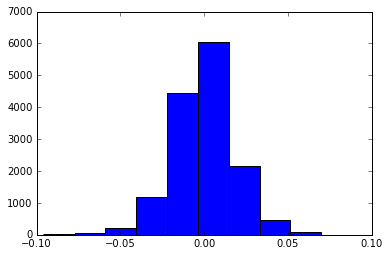

In [61]:
W0 =  param_list[0].get_value()
plt.hist(W.flatten())

In [63]:
batch_size = 1024
N = dataset_list[0][0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = dataset_list[0][2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 101
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.99
        print i_epoch, training_error, test_error
print time.clock() - start_time

0 0.0961915329099 0.101124227047
10 0.0985279530287 0.0987051650882
20 0.0924822688103 0.101299487054
30 0.0993954762816 0.101013019681
40 0.0938825532794 0.093244574964
50 0.102288939059 0.09582593292
60 0.098421163857 0.0981215462089
70 0.101668797433 0.103305138648
80 0.101512312889 0.104277230799
90 0.0980860292912 0.0989768728614
100 0.104551814497 0.0997317507863
361.762806


(array([  1.00000000e+01,   4.20000000e+01,   2.89000000e+02,
          1.72500000e+03,   9.19300000e+03,   2.85000000e+03,
          4.50000000e+02,   8.10000000e+01,   1.90000000e+01,
          4.00000000e+00]),
 array([-0.18877959, -0.14808437, -0.10738915, -0.06669393, -0.02599871,
         0.01469652,  0.05539174,  0.09608696,  0.13678218,  0.1774774 ,
         0.21817262]),
 <a list of 10 Patch objects>)

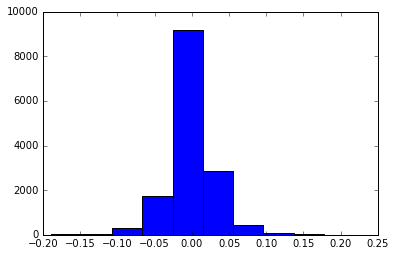

In [64]:
W = param_list[0].get_value()
plt.hist(W.flatten())

(array([  1.10000000e+01,   4.10000000e+01,   3.15000000e+02,
          1.86900000e+03,   9.58900000e+03,   2.36800000e+03,
          3.77000000e+02,   7.10000000e+01,   1.90000000e+01,
          3.00000000e+00]),
 array([-0.17684191, -0.13810491, -0.09936791, -0.0606309 , -0.0218939 ,
         0.0168431 ,  0.05558011,  0.09431711,  0.13305411,  0.17179112,
         0.21052812]),
 <a list of 10 Patch objects>)

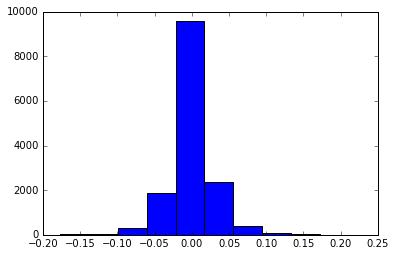

In [65]:
plt.hist((W - W0).flatten())

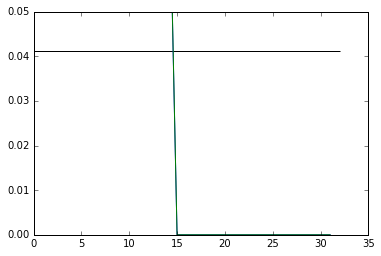

In [56]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.05)
plt.hlines(0.0411, 0, training_error_array.shape[0])

In [57]:
pred_train = TN_utils.predict_original_feature(f_output, fe_vec, norm_coef)
pred_train_vol = pred_train.reshape(vol_shape+(pred_train.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_train_vol, axis=0)[:, :, 15])

TypeError: Missing required input: <TensorType(float32, 3D)>

(430080, 43, 10)


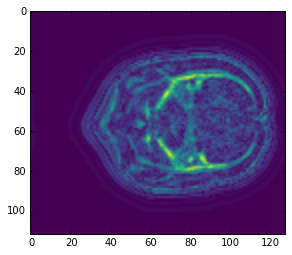

In [11]:
fe_test = TN_utils.load_hardi(i_order=1, i_indiv=1, only_feature=True)
pred_test = TN_utils.predict_original_feature(f_output, fe_test, norm_coef)
pred_test_vol = pred_test.reshape(vol_shape+(pred_test.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_test_vol, axis=0)[:, :, 15])

In [14]:
sio.savemat('../../../results/hardi_in_ex/July6/a2_all_train_1506.mat', {'pred' : pred_train_vol}) 
sio.savemat('../../../results/hardi_in_ex/July6/a2_all_test_1507.mat', {'pred' : pred_test_vol})

In [30]:
len([(0, 2), (2, 2), (2, 4), (4, 4)])

4

In [11]:
[0, 2, 4][1:2]

[2]

In [38]:
import theano
import theano.tensor as T

In [41]:
f_train.get_shared()

[<CudaNdarrayType(float32, 3D)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, vector)>]

In [42]:
param_list

[<CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>,
 <CudaNdarrayType(float32, matrix)>,
 <CudaNdarrayType(float32, vector)>]